In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
%matplotlib inline

In [2]:
log_file_name = 'delay.log'
NUM_GROUPS = 3

In [3]:
class LogResults:
    def __init__(self, time_step):
        self.time_step = time_step
        self.current_time = time_step
        self.current_group = -1
        self.timeslots = []
        self.send_packet_expiration = [[] for _ in range(NUM_GROUPS)]
        self.drop_count_last_byte_fraction = [[] for _ in range(NUM_GROUPS)]
        self.drop_median_slack = [[] for _ in range(NUM_GROUPS)]
        self.drop_slack_fraction = [[] for _ in range(NUM_GROUPS)]
        self.priorities = [[] for _ in range(NUM_GROUPS)]
        self.total_flows = [0] * NUM_GROUPS
        self.sat_flows = [0] * NUM_GROUPS
        self.expired_fraction_in_time = [[] for _ in range(NUM_GROUPS)]
        self.remaining_slack_fraction_on_expiration = [[] for _ in range(NUM_GROUPS)]
        self.remaining_bytes_fraction_on_expiration = [[] for _ in range(NUM_GROUPS)]
    
    def next_time_slot(self):
        self.timeslots.append(self.current_time)
        self.current_time += self.time_step
        self.current_group = -1
    
    def next_group(self):
        self.current_group += 1
        
    def report_priority(self, priority):
        self.priorities[self.current_group].append(priority if priority is not None else 0.0)
    
    def report_median_slack(self, median_slack):
        self.drop_median_slack[self.current_group].append(median_slack)
    
    def report_expired_fraction_in_time(self, data_in_time_fraction):
        self.expired_fraction_in_time[self.current_group].append(
            data_in_time_fraction if data_in_time_fraction is not None else -1.0)
    
    def report_flows_total_satisfied(self, total, satisfied):
        self.total_flows[self.current_group] += total
        self.sat_flows[self.current_group] += satisfied
    
    def report_drop_per_slack_fraction(self, counts):
        self.drop_slack_fraction[self.current_group].append(np.array(counts))
        
    def report_drop_last_byte_fraction(self, counts):
        self.drop_count_last_byte_fraction[self.current_group].append(np.array(counts))
    
    def report_send_packet_expiration_fraction(self, before_time, after_time, counts):
        self.send_packet_expiration[self.current_group].append(np.array([before_time] + list(counts) + [after_time]))
        
    def report_remaining_slack_fraction_on_expiration(self, counts):
        self.remaining_slack_fraction_on_expiration[self.current_group].append(np.array(counts))
        
    def report_remaining_bytes_fraction_on_expiration(self, counts):
        self.remaining_bytes_fraction_on_expiration[self.current_group].append(np.array(counts))
        
    def print_satisfied_report(self):
        print('[ ', end='')
        for s, t in zip(self.sat_flows, self.total_flows):
            print(f'{s}/{t} ', end='')
        print(f'] {sum(self.sat_flows)}/{sum(self.total_flows)}')
        
    def finalize(self):
        self.timeslots = np.array(self.timeslots)
        self.send_packet_expiration = [np.stack(x) for x in self.send_packet_expiration]
        self.drop_count_last_byte_fraction = [np.stack(x) for x in self.drop_count_last_byte_fraction]
        self.drop_median_slack = [np.array(x) for x in self.drop_median_slack]
        self.expired_fraction_in_time = [np.array(x) for x in self.expired_fraction_in_time]
        self.drop_slack_fraction = [np.array(x) for x in self.drop_slack_fraction]
        self.priorities = [np.array(x) for x in self.priorities]
        self.remaining_slack_fraction_on_expiration = [np.stack(x) for x in self.remaining_slack_fraction_on_expiration]
        self.remaining_bytes_fraction_on_expiration = [np.stack(x) for x in self.remaining_bytes_fraction_on_expiration]
        
    def get_xs_ys(self, data):
        xs = self.timeslots.repeat(data.shape[1])
        ys = np.vstack([np.arange(1, data.shape[1] + 1)] * data.shape[0])
        return xs, ys

In [4]:
def parse_log(log_file_name):
    results = LogResults(0.01)
    
    with open(log_file_name) as f:
        for line in f:
            if 'STATS' in line:
                results.next_time_slot()
            elif 'group' in line:
                results.next_group()
            elif 'expiration distr' in line:
                _, _, before_time, _, *in_time, _, after_time = line.split()
                results.report_send_packet_expiration_fraction(int(before_time[1:-1]), int(after_time[1:-1]), [int(x) for x in in_time])
            elif 'drop/last_byte distr' in line:
                _, _, _, *counts, _ = line.split()
                results.report_drop_last_byte_fraction([int(c) for c in counts])
            elif 'drop median slack' in line:
                _, _, _, slack = line.split()
                results.report_median_slack(float(slack) if slack != 'NA' else None)
            elif 'successful (snd) deliveries' in line:
                _, _, _, cur, _, _, cur_sat = line.split()
                results.report_flows_total_satisfied(int(cur), int(cur_sat[:-1]))
            elif 'avg fraction in time:' in line:
                _, _, _, _, frac = line.split()
                results.report_expired_fraction_in_time(float(frac) if frac != 'NA' else None)
            elif 'drop/slack fraction distr:' in line:
                _, _, _, _, *counts, _ = line.split()
                results.report_drop_per_slack_fraction([int(x) for x in counts])
            elif 'avg priority:' in line:
                _, _ , priority = line.split()
                results.report_priority(float(priority) if priority != 'NA' else None)
            elif 'expiration remaining slack fraction:' in line:
                _, _, _, _, *counts = line.split()
                results.report_remaining_slack_fraction_on_expiration([int(x) for x in counts])
            elif 'expiration remaining data fraction:' in line:
                _, _, _, _, *counts = line.split()
                results.report_remaining_bytes_fraction_on_expiration([int(x) for x in counts])
                
    results.print_satisfied_report()
    results.finalize()
    return results
                

    

In [7]:
results = parse_log(log_file_name)

[ 5282/5362 4340/4341 297/297 ] 9919/10000


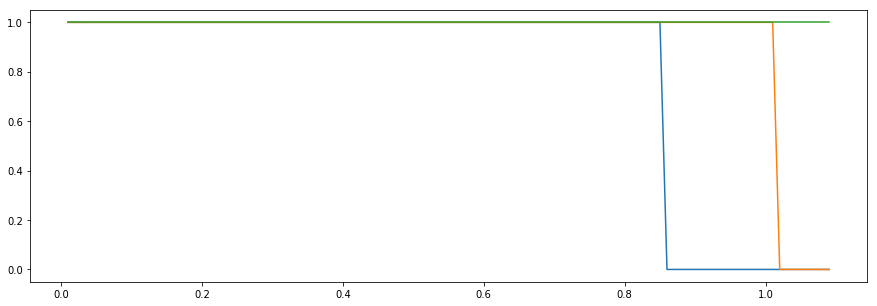

In [572]:
plt.figure(figsize=(15,5))
for group in range(NUM_GROUPS):
    plt.plot(results.timeslots, results.priorities[group])

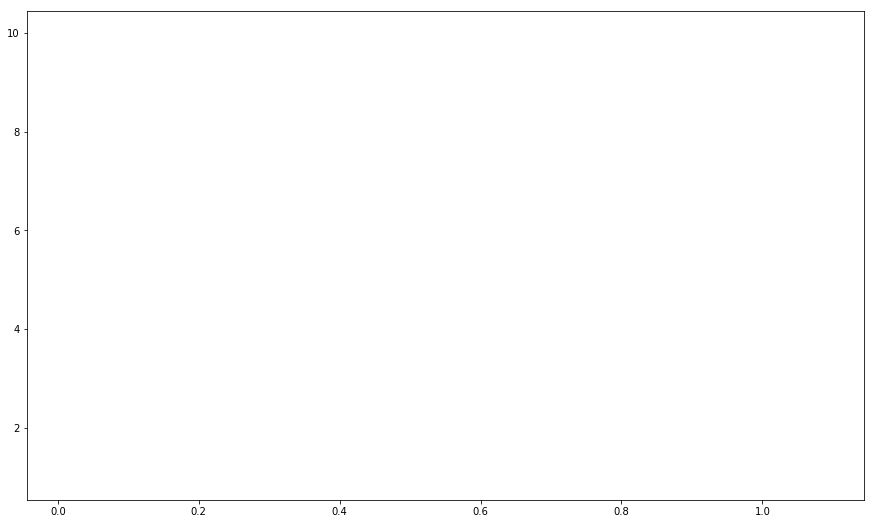

In [573]:
xs, ys = results.get_xs_ys(results.remaining_slack_fraction_on_expiration[0])
plt.figure(figsize=(15,9))
plt.scatter(x = xs, y=ys, s=results.remaining_slack_fraction_on_expiration[0], alpha=0.5)

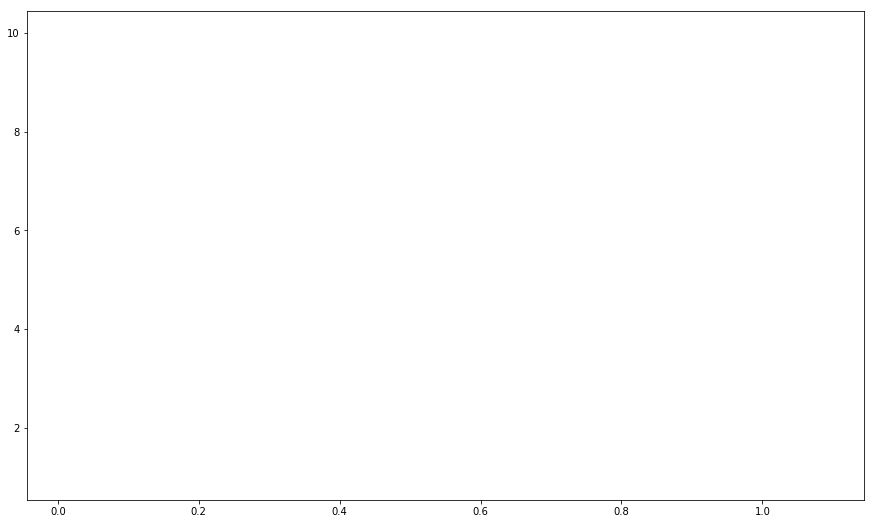

In [574]:
xs, ys = results.get_xs_ys(results.remaining_bytes_fraction_on_expiration[0])
plt.figure(figsize=(15,9))
plt.scatter(x = xs, y=ys, s=results.remaining_bytes_fraction_on_expiration[1], alpha=0.5)

ValueError: 'c' argument has 19 elements, which is not acceptable for use with 'x' with size 1090, 'y' with size 1090.

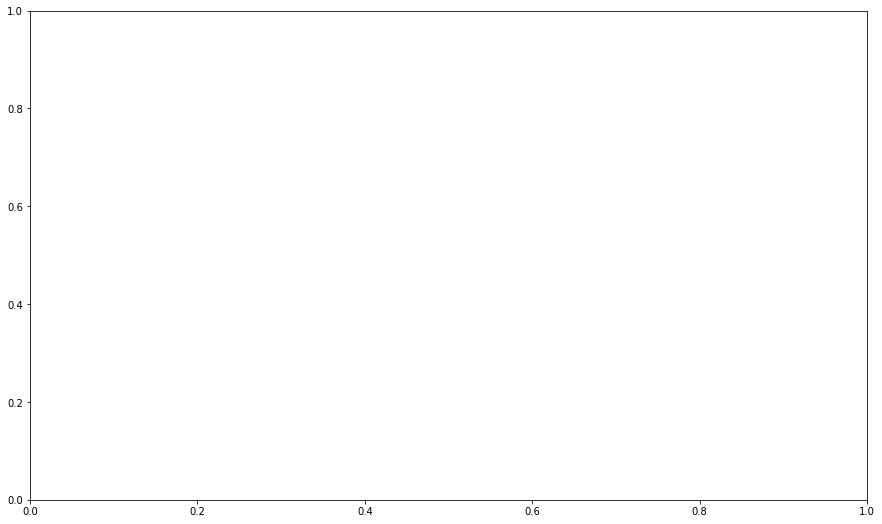

In [575]:
plt.figure(figsize=(15,9))
plt.scatter(x = xs, y=ys, s=edist[1], c=c, alpha=0.5)

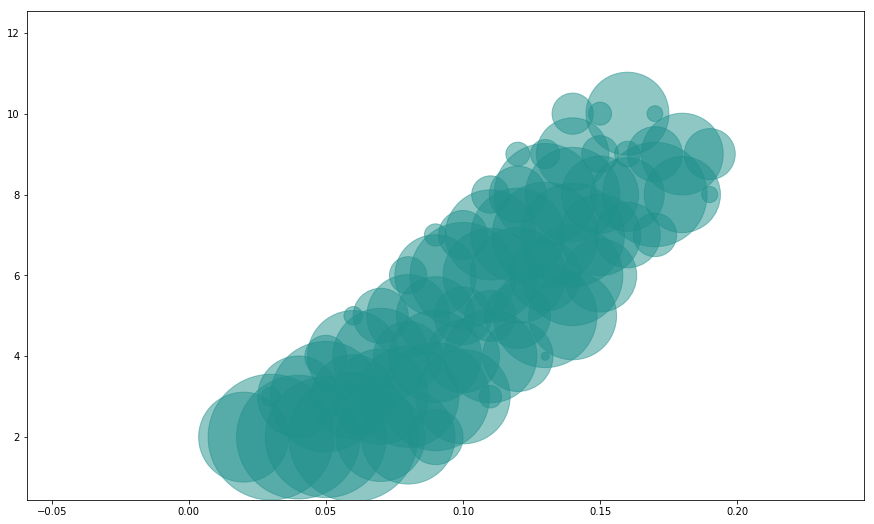

In [348]:
plt.figure(figsize=(15,9))
plt.scatter(x = xs, y=ys, s=edist[2], c=c, alpha=0.5)

In [145]:
xs = ts.repeat(drdist[0].shape[1])
ys = np.vstack([np.arange(1, 11)] * drdist[0].shape[0])

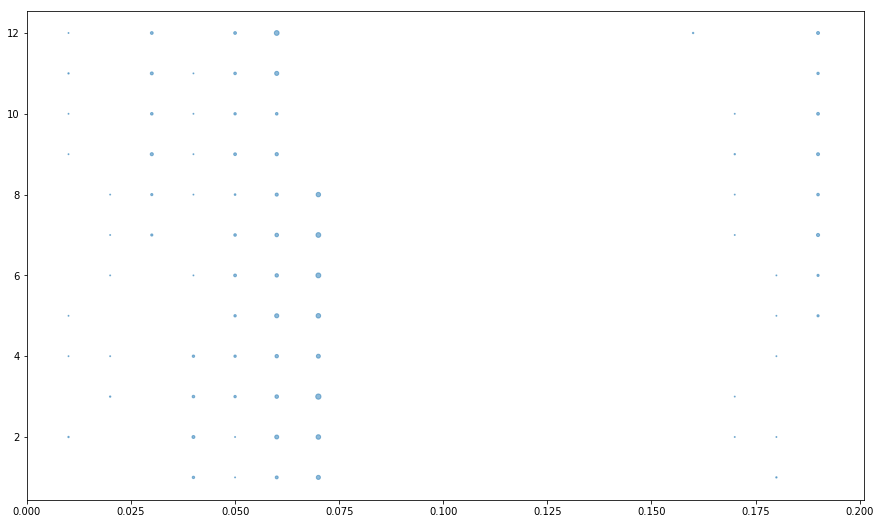

In [349]:
plt.figure(figsize=(15,9))
plt.scatter(x = xs, y=ys, s=drdist[0], alpha=0.5)

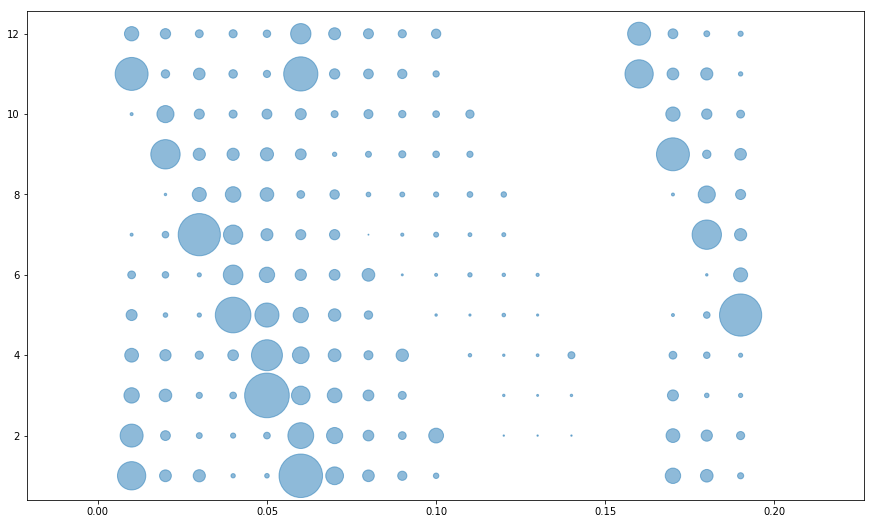

In [350]:
plt.figure(figsize=(15,9))
plt.scatter(x = xs, y=ys, s=drdist[1], alpha=0.5)

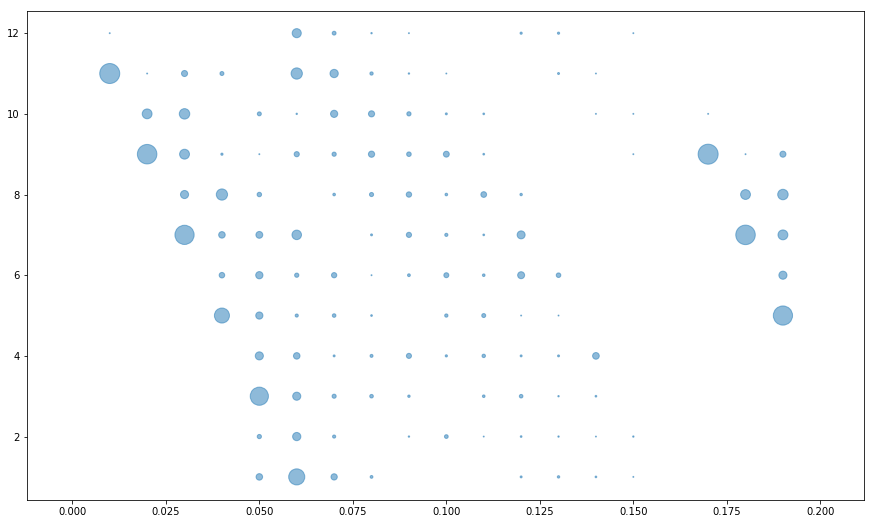

In [351]:
plt.figure(figsize=(15,9))
plt.scatter(x = xs, y=ys, s=drdist[2], alpha=0.5)

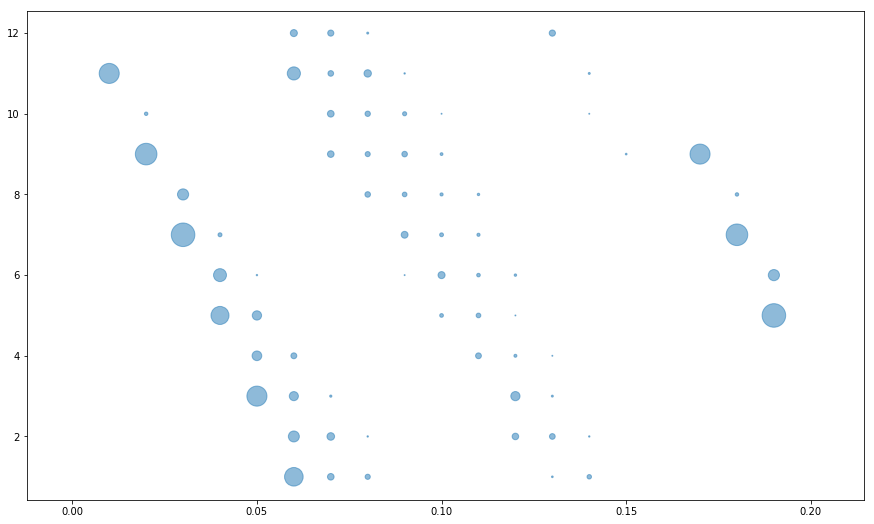

In [352]:
plt.figure(figsize=(15,9))
plt.scatter(x = xs, y=ys, s=drop_slacks[2], alpha=0.5)